# Sentiment analysis with RNNs and LSTMs

This notebook is based on the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and Jon Krohn's Deep Learning for Natural Language Processing LiveLessons. 

#### Load dependencies

In [1]:
import keras
keras.__version__

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint

import os

from sklearn.metrics import roc_auc_score 

import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Directory to store check point files during training

In [3]:
# output directory name:
output_dir = 'model_output/rnn'

#### Load data

In [4]:
n_unique_words = 10000 
print('Loading data...')
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip
print(len(x_train), 'training sequences')
print(len(x_valid), 'validation sequences')

Loading data...
(25000, 'training sequences')
(25000, 'validation sequences')


#### Preprocess data

In [23]:
max_review_length = 500
pad_type = trunc_type = 'pre'
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)

('x_train shape:', (25000, 500))
('x_valid shape:', (25000, 500))


#### Design neural network architecture
1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5 in [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff): they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution 
layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would 
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

## RNN / LSTM models

Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)), or it can return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). These two modes are controlled by the return_sequences constructor argument. 

Changing from RNN to LSTM is as simple as switching SimpleRNN to LSTM in the code

Let's take a look at an example:

In [48]:
# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 32

# RNN layer architecture:
n_rnn = 32 
drop_rnn = 0.0

model = Sequential()
model.add(layers.Embedding(n_unique_words, n_dim))
#model.add(layers.SimpleRNN(32, return_sequences=True))
#model.add(layers.SimpleRNN(32, return_sequences=True))
#model.add(layers.SimpleRNN(32, return_sequences=True))
model.add(layers.SimpleRNN(n_rnn, dropout=drop_rnn))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Configure to store check points

In [50]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train the model
We store the history of the optimization so that we can plot it later

This will take from tens of seconds to minutes per epoch on a laptop depending on hyper parameters and model structure.

Note how at the end of each epoch things come to a halt. This is then the model is evaluated on the validation data.

In [51]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 46s 2ms/step - loss: 0.6040 - acc: 0.6529 - val_loss: 0.5538 - val_acc: 0.7247
Epoch 2/4
25000/25000 [==============================] - 41s 2ms/step - loss: 0.3761 - acc: 0.8433 - val_loss: 0.3701 - val_acc: 0.8372
Epoch 3/4
25000/25000 [==============================] - 38s 2ms/step - loss: 0.2782 - acc: 0.8886 - val_loss: 0.3591 - val_acc: 0.8452
Epoch 4/4
25000/25000 [==============================] - 38s 2ms/step - loss: 0.2020 - acc: 0.9241 - val_loss: 0.3746 - val_acc: 0.8421


#### Display training progress

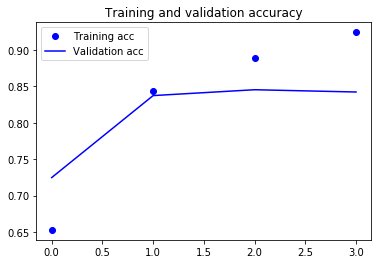

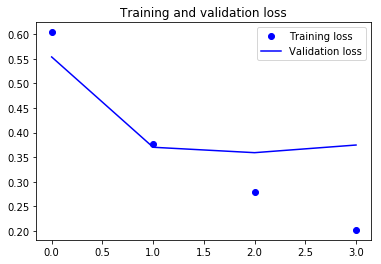

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Load the best model parameters
To do this, look at the training above and pick out the epoch that you consider to be the best. You could also attempt to identify this automatically from the history. Assuming that epoch 1 had the best results, you would load::

    model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [56]:
print('Loading model data...')
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

print('Predict the probabilities...')
y_hat = model.predict_proba(x_valid)

Loading model data...
Predic the probabilities...


#### Calculate the area under the curve for the ROC curve to get a scalar value to express the performance of the network
This code only runs if you ensure that the output is a probability like you would get with a sigmoid (see Jon's model)

In [57]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'80.63'

#### Visualize the output of the classifier

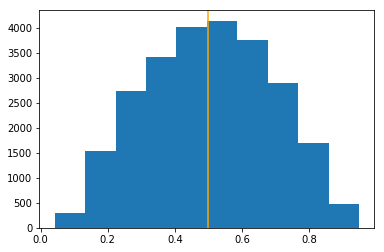

In [58]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

## 1D and 2D convnets

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. 
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.